# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** Rafif Idris Ardhana
- **Email:** a005ybm405@devacademy.id
- **ID Dicoding:** A005YBM405

## Import Semua Packages/Library yang Digunakan

In [1]:
# Sistem & File Handling
import os
import zipfile
import shutil
import random
from random import sample
from tqdm.notebook import tqdm as tq

# Numpy, Pandas dan Visualisasi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers, regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

## Data Preparation

### Data Loading

In [2]:
# Upload file kaggle.json yang kamu unduh dari akun Kaggle
from google.colab import files
files.upload()  # upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rafifidrisardhana","key":"d05fd40062db65f94c45600c6393cfe3"}'}

In [3]:
# Buat folder untuk menyimpan kredensial
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Unduh dataset dari Kaggle
!kaggle datasets download -d puneet6060/intel-image-classification

# Ekstrak zip dataset
with zipfile.ZipFile('intel-image-classification.zip', 'r') as zip_ref:
    zip_ref.extractall('intel_dataset')

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors


### Data Preprocessing

In [4]:
# Direktori awal untuk data train dan test
train_dir = "/content/intel_dataset/seg_train/seg_train"
test_dir = "/content/intel_dataset/seg_test/seg_test"

# Direktori baru untuk dataset gabungan
combined_dir = "/content/intel_dataset/dataset"

In [5]:
# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

In [6]:
# Salin file dan folder dari train
for category in os.listdir(train_dir):
  category_dir = os.path.join(train_dir, category)
  if os.path.isdir(category_dir):
    shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
  category_dir = os.path.join(test_dir, category)
  if os.path.isdir(category_dir):
    shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

Dataset Checking

In [7]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
image_dict = {}

# Path sumber dataset
path = "/content/intel_dataset/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
  image_dict[i] = os.listdir(os.path.join(path_sub, i))

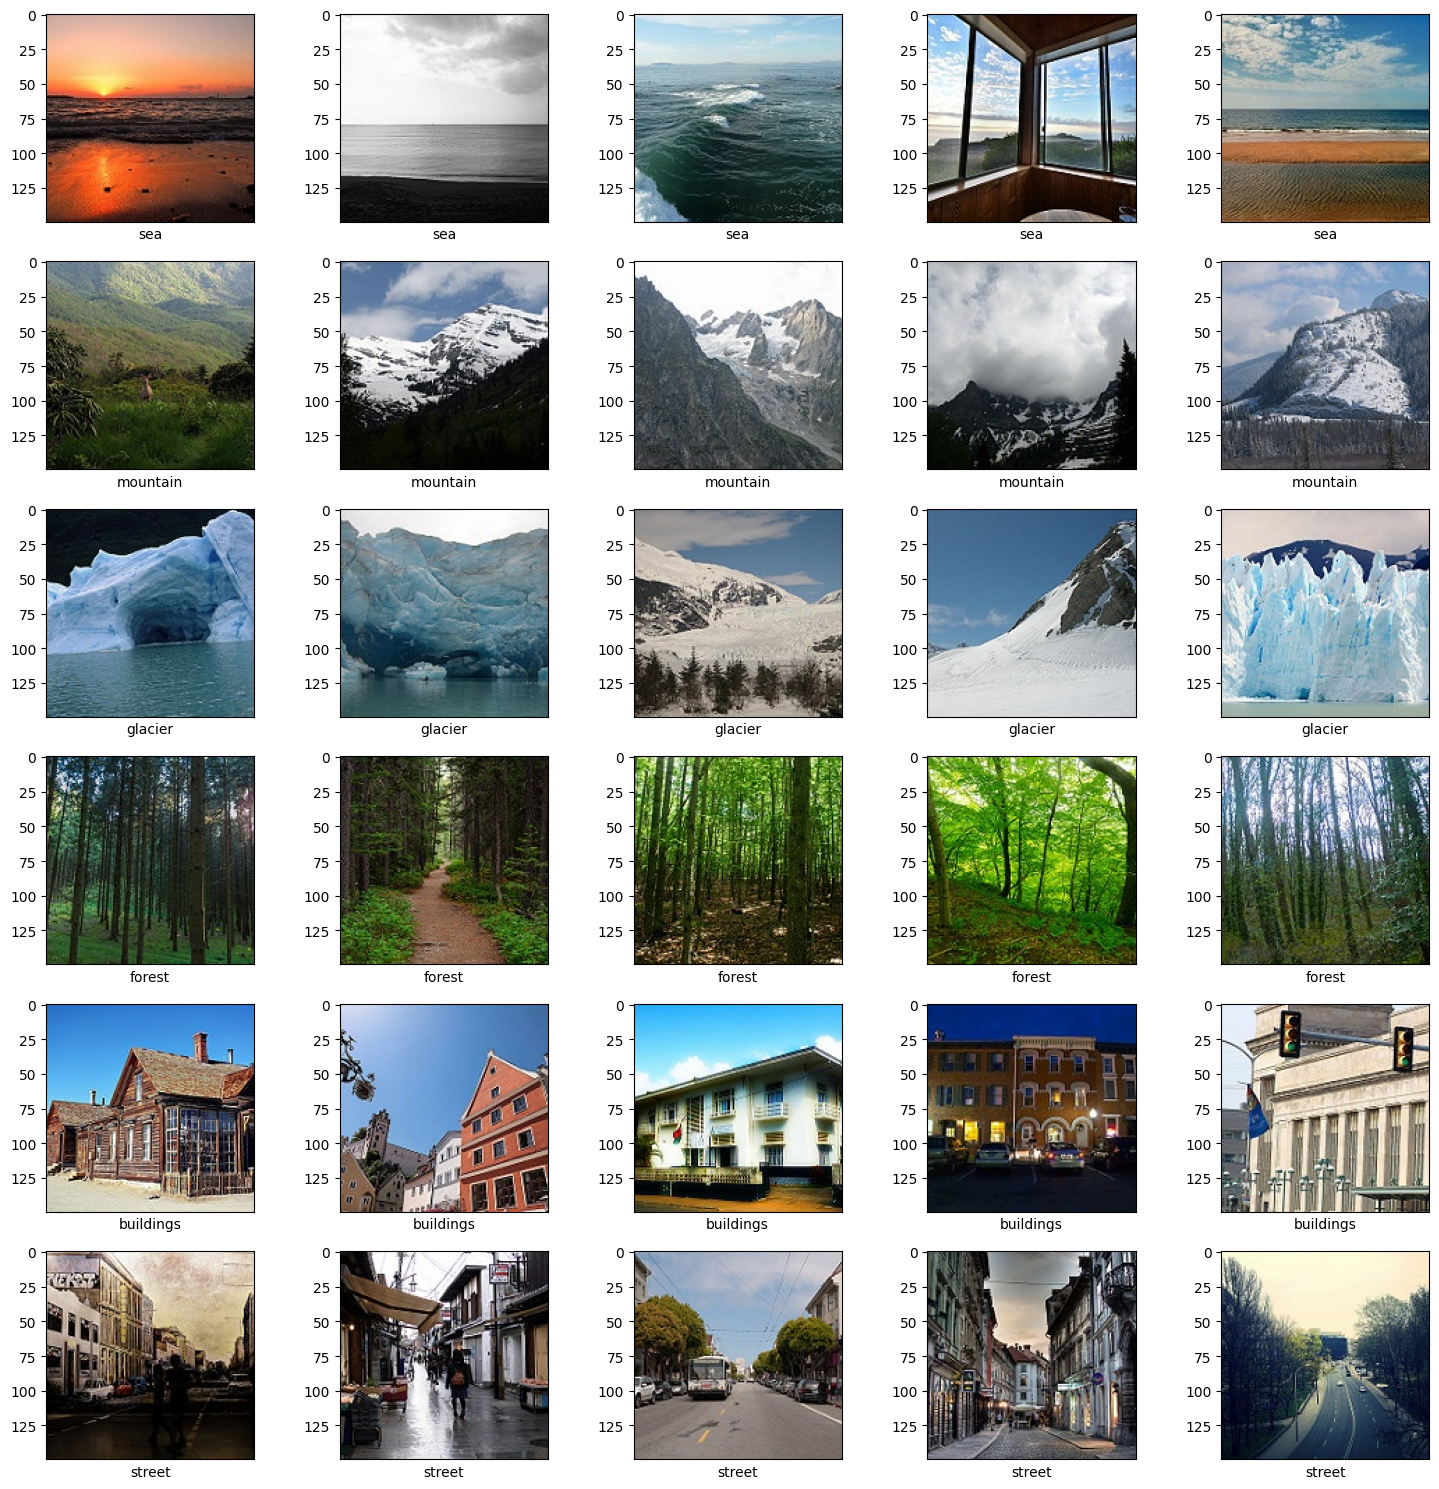

In [8]:
# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(image_dict.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
  images = np.random.choice(image_dict[class_name], 5, replace=False)

  for j, image_name in enumerate(images):
    img_path = os.path.join(path_sub, class_name, image_name)
    img = Image.open(img_path)
    axs[i, j].imshow(img)
    axs[i, j].set_xlabel(class_name)
    axs[i, j].set_xticks([])
    axs[i, j].set_ysticks=([])

  fig.tight_layout()

Plot Distribution

In [9]:
# Path sumber data
source_path = "/content/intel_dataset/dataset"

# Daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(source_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

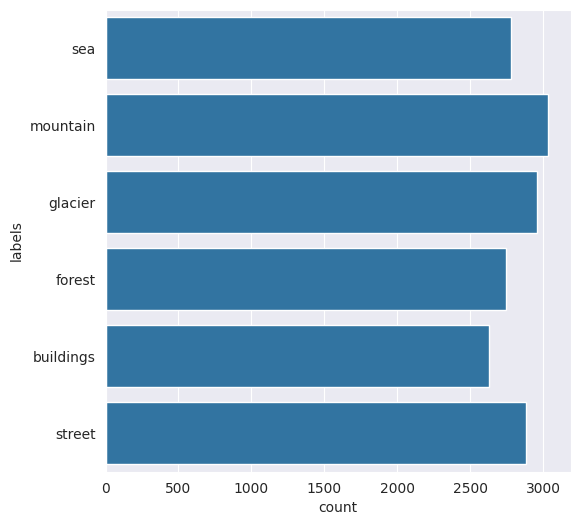

In [10]:
# Plot distribusi gambar di setiap kelas
Label = distribution_train["labels"]

plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

Data Augmentation

In [11]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
  img = cv2.cvtColor(img, 0)
  img = cv2.resize(img, (224,224))
  sudut = random.randint(0,180)
  return rotate(img, sudut)

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
  img = cv2.cvtColor(img, 0)
  img = cv2.resize(img, (224,224))
  sudut = random.randint(0,180)
  return rotate(img, -sudut)

# Membuat fungsi untuk membalik gambar secara vertikal ke bawah
def flip_up_down(img):
  img = cv2.cvtColor(img, 0)
  img = cv2.resize(img, (224,224))
  return np.flipud(img)

# Membuat fungsi untuk memberikan efek pergeseran acak
def sheared_off(img):
  img = cv2.cvtColor(img, 0)
  img = cv2.resize(img, (224,224))
  transform = AffineTransform(shear=0.2)
  shear_image = warp(img, transform, mode="wrap")
  return shear_image

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

In [12]:
# Membuat variabel transformasi yang akan menyimpan semua proses pra-pemrosesan yang telah dilakukan sebelumnya
transformations = { "rotate anticlockwise": anticlockwise_rotation,
                    "rotate clockwise": clockwise_rotation,
                    "flip up down": flip_up_down,
                    "shear image": sheared_off,
                    "blurring image": blur_image,
                    "warp shift": warp_shift,
                    "add brightness": add_brightness
                  }

# Path sumber data (gambar asli)
images_path = "/content/intel_dataset/dataset/"

# Path tujuan (gambar hasil augmentasi)
augmented_path = "/content/intel_dataset/dataset_augmented/"

# Buat folder hasil augmentasi
os.makedirs(augmented_path, exist_ok=True)

images = [] # Penyimpanan gambar setelah preprocessing

# Membaca nama gambar dari folder dan menambahkan path ke dalam array "images"
for root, dirs, files in os.walk(images_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            images.append(os.path.join(root, file))

images_to_generate=7500 # Jumlah gambar yang akan ditambahkan dengan hasil transformasi augmentasi
i=1 # Variabel untuk melakukan iterasi sampai jumlah gambar yang ditentukan dalam images_to_generate

while i<=images_to_generate:
    image_pict=random.choice(images)
    try:
        original_image = io.imread(image_pict)
        transformed_image=None
        n = 0      # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
        transformation_count = random.randint(1, len(transformations)) # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

        while n <= transformation_count:
            key = random.choice(list(transformations)) # Secara acak memilih dan memanggil metode
            transformed_image = transformations[key](original_image)
            n = n + 1

        # Mengambil nama folder (label) dari gambar asli
        label = os.path.basename(os.path.dirname(image_pict))
        label_folder = os.path.join(augmented_path, label)
        os.makedirs(label_folder, exist_ok=True)

        new_image_path= os.path.join(label_folder, f"augmented_image_{i}.jpg")
        transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
        i =i+1
    except ValueError as e:
        print('could not read the',image_pict ,':',e,'hence skipping it.')

In [13]:
# Daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(augmented_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

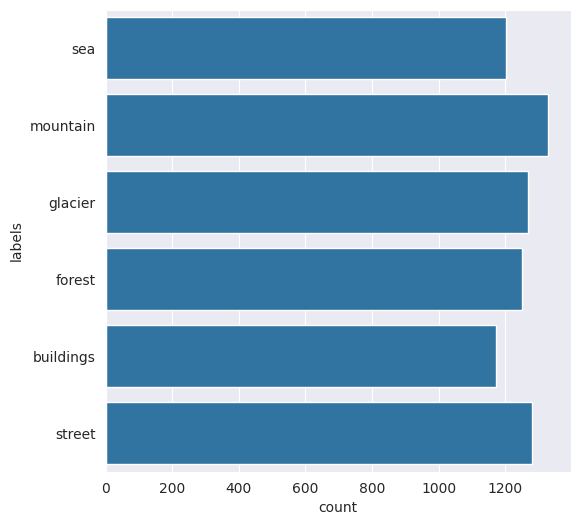

In [14]:
# Plot distribusi gambar di setiap kelas
Label = distribution_train["labels"]

plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [15]:
# Menggabungkan folder dataset original dan dataset augmented

# Path folder asli dan folder augmentasi
original_path = "/content/intel_dataset/dataset"
augmented_path = "/content/intel_dataset/dataset_augmented"
combined_path = "/content/intel_dataset/dataset_combined"

# Membuat folder gabungan
os.makedirs(combined_path, exist_ok=True)

# Menggabungkan subfolder (kelas) dari kedua folder
for source_path in [original_path, augmented_path]:
    for class_name in os.listdir(source_path):
        class_folder = os.path.join(source_path, class_name)
        if os.path.isdir(class_folder):
            target_class_folder = os.path.join(combined_path, class_name)
            os.makedirs(target_class_folder, exist_ok=True)

            for file_name in os.listdir(class_folder):
                src_file = os.path.join(class_folder, file_name)
                dst_file = os.path.join(target_class_folder, file_name)
                if not os.path.exists(dst_file):  # Hindari duplikat nama file
                    shutil.copy2(src_file, dst_file)

#### Split Dataset

In [16]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= "/content/intel_dataset/dataset_combined"

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,"file_name":file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(["labels"]).size()

labels
buildings    3801
forest       3994
glacier      4225
mountain     4366
sea          3986
street       4162
dtype: int64

In [17]:
# Membuat variabel pemisahan, variabel X = data path dan variabel y = data labels
X = df["path"]
y = df["labels"]

# Split dataset menjadi data train dan data test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=300)

In [18]:
# Membuat data frame masing-masing untuk data train dan data test
df_train = pd.DataFrame({"path":X_train, "labels":y_train, "set":"train"})
df_test = pd.DataFrame({"path":X_test, "labels":y_test, "set":"test"})

In [19]:
# Menggabungkan DataFrame df_train dan df_test
df_all = pd.concat([df_train, df_test], ignore_index=True)

print("===================================================== \n")
print(df_all.groupby(["set", "labels"]).size(), '\n')
print("===================================================== \n")

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "/content/intel_dataset/dataset_combined"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "/content/intel_dataset/dataset_final/"


set    labels   
test   buildings     730
       forest        856
       glacier       867
       mountain      871
       sea           747
       street        836
train  buildings    3071
       forest       3138
       glacier      3358
       mountain     3495
       sea          3239
       street       3326
dtype: int64 


                                                    path     labels    set
624    /content/intel_dataset/dataset_combined/buildi...  buildings  train
12742  /content/intel_dataset/dataset_combined/mounta...   mountain  train
3836   /content/intel_dataset/dataset_combined/forest...     forest  train
18781  /content/intel_dataset/dataset_combined/buildi...  buildings  train
6808   /content/intel_dataset/dataset_combined/mounta...   mountain  train


In [20]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row["path"]
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row["labels"],row["image"].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row["set"],row["labels"])) == False:
        os.makedirs(os.path.join(dataset_path,row["set"],row["labels"]))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row["set"],row["labels"],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [21]:
# Membuat path direktori data train dan data test
TRAIN_DIR = "/content/intel_dataset/dataset_final/train"
TEST_DIR = "/content/intel_dataset/dataset_final/test"

In [22]:
# Membuat objek ImageDataGenerator untuk menormalkan gambar
datagen = ImageDataGenerator(rescale=1/255., validation_split= 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(224,224),
                                              class_mode="categorical",
                                              subset="training",
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(224,224),
                                                   class_mode="categorical",
                                                   subset="validation",
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(224,224),
                                                  class_mode="categorical",
                                                  shuffle=False)

Found 15704 images belonging to 6 classes.
Found 3923 images belonging to 6 classes.
Found 4907 images belonging to 6 classes.


## Modelling

In [23]:
optimizer = Adam(learning_rate=0.0005)

# Menerapkan transfer learning
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False

# Membuat model
model = Sequential([
    base_model,
    Conv2D(64, (3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    GlobalAveragePooling2D(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation="softmax")
])

model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 64)       │       737,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,087,238 (11.78 MB)

 Trainable params: 828,870 (3.16 MB)

 Non-trainable params: 2,258,368 (8.61 MB)

In [24]:
# Menghitung bobot kelas untuk menangani ketidakseimbangan kelas dalam dataset

# Hitung jumlah data per kelas di training set
label_counts = df_train["labels"].value_counts().sort_index()

# Hitung total sample & jumlah kelas
total_samples = label_counts.sum()
num_classes = len(label_counts)

# Hitung class weight dengan rumus (1/ count_k) *(total_samples / num_classes)
class_weights = {}

# Membuat mapping label string ke angka
label_to_index = {label: idx for idx, label in enumerate(label_counts.index)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

# Looping tiap kelas
for label, count in label_counts.items():
  class_idx = label_to_index[label],
  weight = (1.0 / count) * (total_samples / num_classes)
  class_weights[class_idx] = weight

# Print hasil
print("Label to index mapping:")
print(label_to_index)
print("\nClass weights:")
print(class_weights)

Label to index mapping:
{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}

Class weights:
{(0,): np.float64(1.065179637468794), (1,): np.float64(1.042436796260888), (2,): np.float64(0.974141353980544), (3,): np.float64(0.9359561278016214), (4,): np.float64(1.0099310486775754), (5,): np.float64(0.9835137302064542)}


In [25]:
# Training Model

# Membuat custom stopping
class CustomEarlyStopping(Callback):
  def __init__(self, train_target=0.95, val_target=0.90):
    super(CustomEarlyStopping, self).__init__()
    self.train_target = train_target
    self.val_target = val_target

  def on_epoch_end(self, epoch, logs=None):
    train_acc = logs.get("accuracy")
    val_acc = logs.get("val_accuracy")
    if train_acc is not None and val_acc is not None:
      if train_acc >= self.train_target and val_acc >= self.val_target:
        print(f"\nTarget tercapai: Akurasi Pelatihan = {train_acc:.4f}, Akurasi Validasi = {val_acc:.4f}")
        self.model.stop_training = True

# Callback
custom_early_stopping = CustomEarlyStopping(train_target=0.95, val_target=0.90)

# Callback tambahan
lr_schedule = ReduceLROnPlateau(
    monitor="val_loss",
    patience=3,
    factor=0.5,
    verbose=1,
    min_lr=1e-6
)

# Training
history = model.fit(
    train_generator,
    epochs=50,
    batch_size=32,
    validation_data=validation_generator,
    class_weight = class_weights,
    callbacks=[custom_early_stopping, lr_schedule]
)

acc = history.history["accuracy"][-1]
print(f"Akurasi pelatihan data: {acc}")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


491/491 ━━━━━━━━━━━━━━━━━━━━ 57s 89ms/step - accuracy: 0.7390 - loss: 0.7483 - val_accuracy: 0.9039 - val_loss: 0.2601 - learning_rate: 5.0000e-04
Epoch 2/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 32s 64ms/step - accuracy: 0.8857 - loss: 0.3258 - val_accuracy: 0.8878 - val_loss: 0.2945 - learning_rate: 5.0000e-04
Epoch 3/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - accuracy: 0.9133 - loss: 0.2526 - val_accuracy: 0.9098 - val_loss: 0.2737 - learning_rate: 5.0000e-04
Epoch 4/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9341 - loss: 0.1792
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
491/491 ━━━━━━━━━━━━━━━━━━━━ 39s 65ms/step - accuracy: 0.9341 - loss: 0.1792 - val_accuracy: 0.8970 - val_loss: 0.3158 - learning_rate: 5.0000e-04
Epoch 5/50
490/491 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9578 - loss: 0.1202
Target tercapai: Akurasi Pelatihan = 0.9629, Akurasi Validasi = 0.9105
491/491 ━━━━━━━━━━━━━━━━━━━━ 33s 67ms/step - accuracy: 0.9578 - loss:

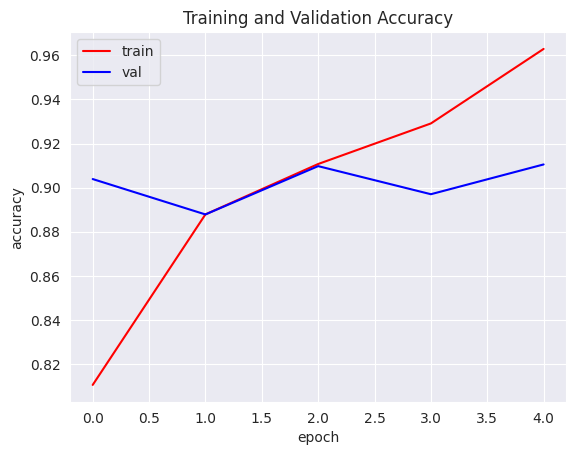

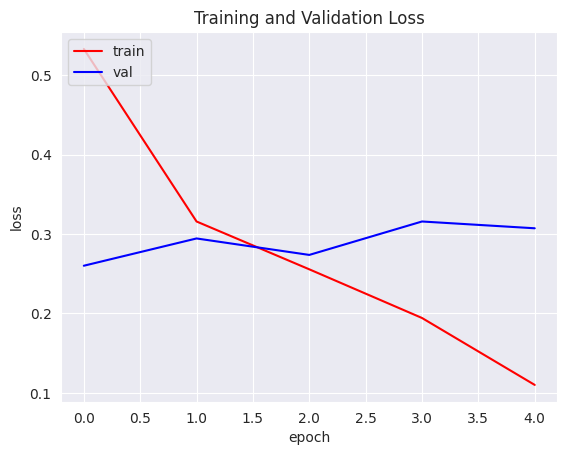

In [26]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

### Evaluasi dan Visualisasi

4907/4907 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step


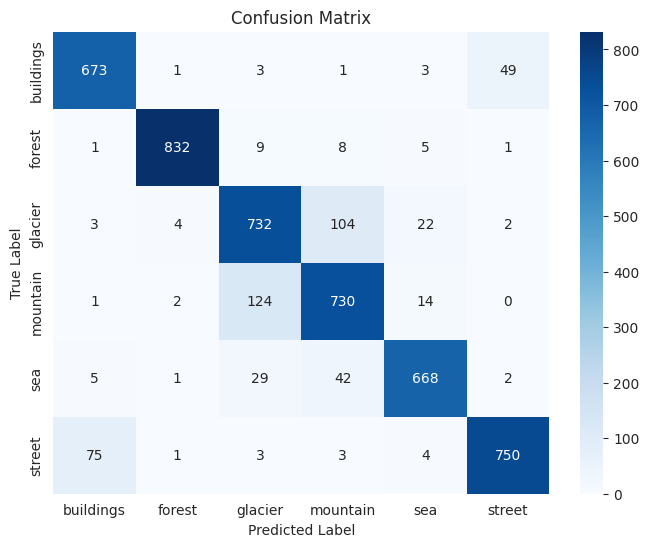


Classification Report:
              precision    recall  f1-score   support

   buildings     0.8879    0.9219    0.9046       730
      forest     0.9893    0.9720    0.9806       856
     glacier     0.8133    0.8443    0.8285       867
    mountain     0.8221    0.8381    0.8300       871
         sea     0.9330    0.8942    0.9132       747
      street     0.9328    0.8971    0.9146       836

    accuracy                         0.8936      4907
   macro avg     0.8964    0.8946    0.8952      4907
weighted avg     0.8952    0.8936    0.8942      4907



In [27]:
test_generator.reset()

# Prediksi probabilitas kelas
pred_probs = model.predict(test_generator, verbose=1)

# Mengambil prediksi label (kelas dengan probabilitas tertinggi)
pred_classes = np.argmax(pred_probs, axis=1)

# Label aktual dari generator
true_classes = test_generator.classes

# Nama kelas dari generator
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_classes, pred_classes)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(true_classes, pred_classes, target_names=class_labels, digits=4))

## Konversi Model

Saved Model

In [31]:
model.export("model_saved")

Saved artifact at 'model_saved'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  134559740071376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134559740074448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134559740075408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134559740075216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134559740072528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134559740070992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134559740075024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134559740074256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134559740073680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134559740076368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134559740077712

In [32]:
from google.colab import files

!zip -r saved_model.zip model_saved/
files.download('saved_model.zip')

  adding: model_saved/ (stored 0%)
  adding: model_saved/fingerprint.pb (stored 0%)
  adding: model_saved/assets/ (stored 0%)
  adding: model_saved/saved_model.pb (deflated 90%)
  adding: model_saved/variables/ (stored 0%)
  adding: model_saved/variables/variables.index (deflated 78%)
  adding: model_saved/variables/variables.data-00000-of-00001 (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

TFLite

In [33]:
converter = tf.lite.TFLiteConverter.from_saved_model("model_saved")
tflite_model = converter.convert()

# Simpan ke file
with open("model.tflite", "wb") as f:
  f.write(tflite_model)

In [34]:
files.download('model.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

TFJS

In [35]:
!pip install tensorflowjs

# Convert to TFJS
!tensorflowjs_converter --input_format=tf_saved_model \
    --output_node_names='dense_1/Softmax' \
    --saved_model_tags=serve \
    model_saved tfjs_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
2025-04-16 02:25:40.011224: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744770340.032370    7576 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:174

In [36]:
!zip -r tfjs_model.zip tfjs_model/
files.download('tfjs_model.zip')

  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/model.json (deflated 96%)
  adding: tfjs_model/group1-shard1of3.bin (deflated 7%)
  adding: tfjs_model/group1-shard3of3.bin (deflated 7%)
  adding: tfjs_model/group1-shard2of3.bin (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference

Menggunakan TF-Lite

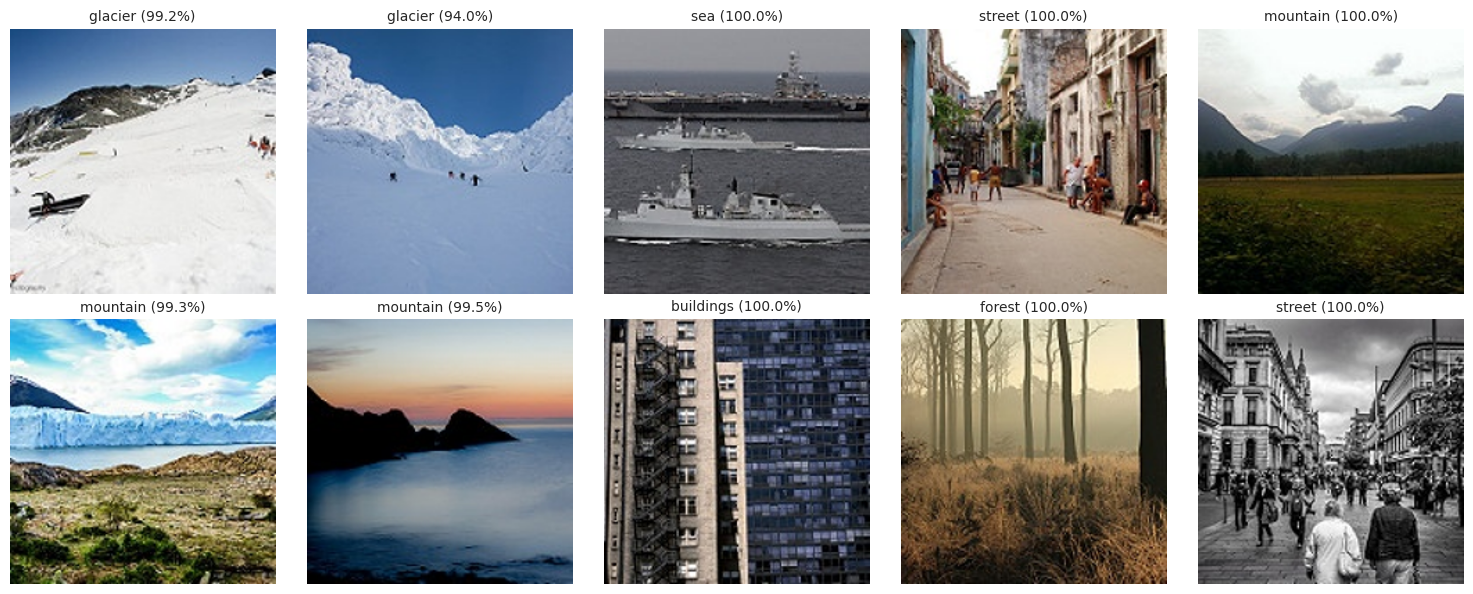

In [40]:
# Path ke direktori gambar
image_dir = "/content/intel_dataset/seg_pred/seg_pred"

# Format gambar yang diperbolehkan
image_extensions = ['.jpg', '.jpeg', '.png']

# Ambil file gambar yang valid
image_files = [f for f in os.listdir(image_dir) if any(f.endswith(ext) for ext in image_extensions)]
image_files = random.sample(image_files, min(10, len(image_files))) # 10 gambar acak

# Load model
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load label
with open("label.txt", "r") as f:
    labels = [line.strip() for line in f.readlines()]

# Setup plot: 2 baris x 5 kolom
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()  # Ubah jadi 1D array agar bisa diakses pakai indeks biasa

# Proses dan tampilkan gambar
for idx, image_file in enumerate(image_files):
    image_path = os.path.join(image_dir, image_file)

    img = Image.open(image_path).resize((224, 224))
    img_array = np.array(img).astype(np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()
    pred = interpreter.get_tensor(output_details[0]['index'])[0]

    predicted_index = np.argmax(pred)
    predicted_label = labels[predicted_index]
    confidence = pred[predicted_index] * 100

    axes[idx].imshow(img)
    axes[idx].set_title(f"{predicted_label} ({confidence:.1f}%)", fontsize=10)
    axes[idx].axis('off')

# Matikan sisa subplot jika gambar < 10
for j in range(len(image_files), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [41]:
pip freeze > requirements.txt